In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import ast
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error



In [2]:
ratings = pd.read_csv(r'filtered_ratings.csv')
ratings.rename(columns={'Rating': 'rating'}, inplace=True)
ratings.rename(columns={'UserID': 'userId'}, inplace=True)
ratings.rename(columns={'MovieID': 'movieId'}, inplace=True)

All_parts_objects = pd.read_csv(r'1M_YOLO_features.csv', index_col=1)
columns_to_keep = [str(i) for i in range(80)]
movies_features = All_parts_objects[columns_to_keep]

# Remove rows where all features are 0
movies_features = movies_features[(movies_features != 0).any(axis=1)]
movies_metadata = pd.read_csv(r'1M_BERT_embeddings_tag_and_whisper_trans.csv')


unique_movieids_ratings = ratings['movieId'].unique()
unique_movieids_movies_metadata = movies_metadata['movieId'].unique()
unique_movieids_movies_features = movies_features.index.unique()

common_movieids = list(set(unique_movieids_movies_metadata) & set(unique_movieids_ratings) & set(unique_movieids_movies_features))

ratings = ratings[ratings['movieId'].isin(common_movieids)]
movies_metadata = movies_metadata[movies_metadata['movieId'].isin(common_movieids)]
movies_features = movies_features.iloc[movies_features.index.isin(common_movieids)]



In [3]:
# Method 1: Collaborative Filtering
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
item_user_matrix_filled = user_item_matrix.T.fillna(0.5)
item_similarity_cf = cosine_similarity(item_user_matrix_filled)
item_similarity_df_cf = pd.DataFrame(item_similarity_cf, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# Method 2: Metadata-based Similarity
item_metadata_matrix_filled = movies_features.fillna(0)
item_similarity_metadata = cosine_similarity(item_metadata_matrix_filled)
item_similarity_df_metadata = pd.DataFrame(item_similarity_metadata, index=item_metadata_matrix_filled.index, columns=item_metadata_matrix_filled.index)
threshold = 0.3
item_similarity_df_metadata_thresholded = item_similarity_df_metadata.applymap(lambda x: x if x > threshold else 0)

# Method 3: BERT-based Similarity
def string_to_array(s):
    s = s.strip('[]')
    return np.array([float(x) for x in s.split()])

movies_metadata['bert_embedding'] = movies_metadata['bert_embedding'].apply(string_to_array)
movie_embeddings = np.stack(movies_metadata['bert_embedding'].values)
cosine_sim_bert = cosine_similarity(movie_embeddings, movie_embeddings)
item_similarity_df_bert = pd.DataFrame(cosine_sim_bert, index=movies_metadata['movieId'], columns=movies_metadata['movieId'])

# Split the ratings data into training and testing sets
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

# Function to get k-nearest neighbors
def get_k_nearest_neighbors(item_similarity_df, movie_id, k=255):
    if movie_id not in item_similarity_df.columns:
        return pd.Index([])
    sim_scores = item_similarity_df[movie_id]
    nearest_neighbors = sim_scores.sort_values(ascending=False).index[:k]
    return nearest_neighbors

# Function to predict rating
def predict_rating(user_item_matrix, item_similarity_df, user_id, movie_id, k=255):
    nearest_neighbors = get_k_nearest_neighbors(item_similarity_df, movie_id, k)
    if nearest_neighbors.empty:
        return 0
    neighbor_ratings = user_item_matrix.loc[user_id, nearest_neighbors]
    if neighbor_ratings.isna().all():
        return 0
    return neighbor_ratings.mean()




/tmp/ipykernel_1267525/510463749.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  item_similarity_df_metadata_thresholded = item_similarity_df_metadata.applymap(lambda x: x if x > threshold else 0)


In [4]:
# Evaluate at K=255 for combined predictions
K = 255

y_true_all = []
y_pred_all = []

for index, row in test_ratings.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    y_true_all.append(row['rating'])
    
    # Predictions from the three methods
    #pred_cf = predict_rating(user_item_matrix, item_similarity_df_cf, user_id, movie_id, k=K)
    #pred_metadata = predict_rating(user_item_matrix, item_similarity_df_metadata_thresholded, user_id, movie_id, k=K)
    pred_bert = predict_rating(user_item_matrix, item_similarity_df_bert, user_id, movie_id, k=K)
    
    # Combine predictions by averaging
    combined_prediction = np.mean([ pred_bert])
    y_pred_all.append(combined_prediction)

# Convert to floats
y_true_all = [float(val) for val in y_true_all]
y_pred_all = [float(val) for val in y_pred_all]

# Calculate RMSE
rmse = mean_squared_error(y_true_all, y_pred_all, squared=False)
print("RMSE:", rmse)

# Calculate MAE
mae = mean_absolute_error(y_true_all, y_pred_all)
print("MAE:", mae)

# Calculate MSE
mse = mean_squared_error(y_true_all, y_pred_all, squared=True)
print("MSE:", mse)

RMSE: 0.9623791281698783
MAE: 0.7624492317835855
MSE: 0.9261735863370149


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


K=5: RMSE=0.510685438778866, MAE=0.2664570973974315, MSE=0.2607996173807629


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


K=10: RMSE=0.6429680524231118, MAE=0.40171596339410864, MSE=0.41340791643676955


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


K=20: RMSE=0.752144622496103, MAE=0.5260740404911525, MSE=0.5657215331498053


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


K=50: RMSE=0.8590663641980748, MAE=0.649889305163489, MSE=0.7379950180964994


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


K=100: RMSE=0.9138800129237187, MAE=0.7111590628765144, MSE=0.8351766780214561


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


K=150: RMSE=0.937843966346086, MAE=0.7370032416198975, MSE=0.8795513052117586


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


K=200: RMSE=0.9517316550462938, MAE=0.751741766294557, MSE=0.9057931432171575


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


K=255: RMSE=0.9623791281698783, MAE=0.7624492317835855, MSE=0.9261735863370149


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


K=500: RMSE=0.9849878017959942, MAE=0.7842692809705736, MSE=0.9702009696869047


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


K=750: RMSE=0.9954652336265477, MAE=0.7937489535275054, MSE=0.9909510313591573


/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/patel8m6/Desktop/python scripts/mldl/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


K=1000: RMSE=1.001952885625786, MAE=0.799394095141966, MSE=1.0039095850138395


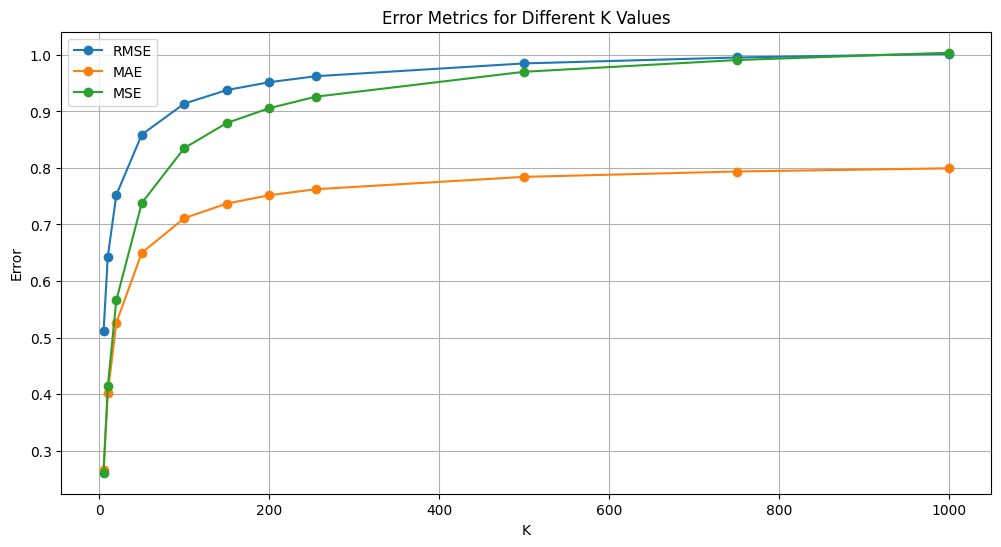

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# List of different K values
K_values = [5, 10, 20, 50, 100, 150, 200, 255,500,750,1000]

# Initialize lists to store the metrics for each K
rmse_values = []
mae_values = []
mse_values = []

for K in K_values:
    y_true_all = []
    y_pred_all = []
    
    for index, row in test_ratings.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        y_true_all.append(row['rating'])
        
        # Predictions from the three methods
        #pred_cf = predict_rating(user_item_matrix, item_similarity_df_cf, user_id, movie_id, k=K)
        #pred_metadata = predict_rating(user_item_matrix, item_similarity_df_metadata_thresholded, user_id, movie_id, k=K)
        pred_bert = predict_rating(user_item_matrix, item_similarity_df_bert, user_id, movie_id, k=K)
        
        # Combine predictions by averaging
        combined_prediction = np.mean([pred_bert])
        y_pred_all.append(combined_prediction)

    # Convert to floats
    y_true_all = [float(val) for val in y_true_all]
    y_pred_all = [float(val) for val in y_pred_all]

    # Calculate RMSE
    rmse = mean_squared_error(y_true_all, y_pred_all, squared=False)
    rmse_values.append(rmse)
    
    # Calculate MAE
    mae = mean_absolute_error(y_true_all, y_pred_all)
    mae_values.append(mae)
    
    # Calculate MSE
    mse = mean_squared_error(y_true_all, y_pred_all, squared=True)
    mse_values.append(mse)
    
    # Print metrics for the current K
    print(f"K={K}: RMSE={rmse}, MAE={mae}, MSE={mse}")

# Plot the metrics for different K values
plt.figure(figsize=(12, 6))
plt.plot(K_values, rmse_values, label='RMSE', marker='o')
plt.plot(K_values, mae_values, label='MAE', marker='o')
plt.plot(K_values, mse_values, label='MSE', marker='o')
plt.xlabel('K')
plt.ylabel('Error')
plt.title('Error Metrics for Different K Values')
plt.legend()
plt.grid(True)
plt.show()
